# New interesting stochastic phenomena

In [2]:
import numpy as np
from scipy.stats import pareto
from tqdm import tqdm

beta = 1.9

# Impact parameter distribution
def generate_impact_parameter(R, n, size):
    u = np.random.uniform(0, 1, size)
    b = R * (u)**(1/n)
    return b

# Mass distribution combined with impact parameter 
def generate_samples(N, M_min, M_max, R):
    ms = []
    while (len(ms) < N):
        m = M_min **(beta-1) * pareto.rvs(beta-1, size=N-len(ms))
        m = m[m < M_max]
        ms.extend(m[M_min**(beta-1) <= m])
    ms = np.array(ms[:N])
    bs =  generate_impact_parameter(R,2, size=N) 
    angles = np.cos(np.random.uniform(0, 2 * np.pi, size=N))
    results = np.sum((angles) * ms * (1/bs))
    return results

# Computing many iterations
def compute_distribution(N, M_min, M_max, R, iterations):
    results = np.zeros(iterations)
    for i in tqdm(range(iterations), desc="Computing Samples"):
        results[i] = generate_samples(N, M_min, M_max, R)
    return results

# Parameters
M_min1 = 1
M_min2 = 1
N1 = 100
N2 = 1000 #int(np.round((M_min1 / M_min2)**(beta-1) * N1))
M_max1 = 1e2
M_max2 = 1e2
iterations = 100000
R = 5

# Generate distributions
res1 = compute_distribution(N1, M_min1, M_max1, R, iterations)
res2 = compute_distribution(N2, M_min2, M_max2, R, iterations)

# Output results
print("Mean of dist1:", np.mean(res1))
print("Mean of dist2:", np.mean(res2))

Computing Samples: 100%|██████████████| 100000/100000 [00:20<00:00, 4813.19it/s]

Mean of dist1: -0.12301380129704328
Mean of dist2: -0.9058002225251199


Fraction1: 0.9938317345242623 Fraction2: 0.9521022467921082


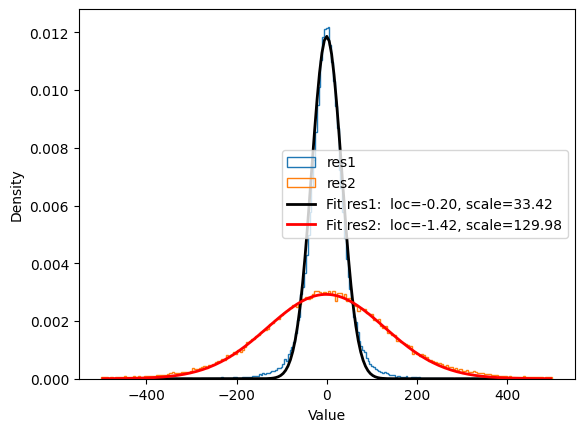

In [23]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.stats import laplace
from scipy.stats import t
from scipy.stats import cauchy

x_range1 = 400
x_range2 = 500

count1, sec1 = np.histogram(res1,bins= np.linspace(-x_range1,x_range1,150),density = True)
mid1 = np.array([(sec1[i+1] + sec1[i])/2 for i in range(len(sec1)-1)])

count2, sec2 = np.histogram(res2,bins= np.linspace(-x_range2,x_range2, 150),density = True)
mid2 = np.array([(sec2[i+1] + sec2[i])/2 for i in range(len(sec2)-1)])

#Cut the data to not include all of the tail

cut1 = 200
cut2 = 300

mask1 = np.abs(mid1) < cut1
mask2 = np.abs(mid2) < cut2

fraction1 = np.sum(count1[mask1])/np.sum(count1)
fraction2 = np.sum(count2[mask2])/np.sum(count2)

print("Fraction1:", fraction1, "Fraction2:", fraction2)

def gaussian1(x,m,s):
    return (fraction1/np.sqrt(s**2*2*np.pi))*np.exp(-(x-m)**2/(2*s**2))

def gaussian2(x,m,s):
    return (fraction2/np.sqrt(s**2*2*np.pi))*np.exp(-(x-m)**2/(2*s**2))


# Plot the histograms
plt.hist(res1, bins=np.linspace(-x_range1,x_range1,200), density = True,histtype='step', label='res1')
plt.hist(res2, bins=np.linspace(-x_range2,x_range2,200), density = True, histtype='step', label='res2')

# Fit the model to the data
params1, covariance1 = curve_fit(gaussian1, mid1[mask1], count1[mask1],p0 = [0,10])
params2, covariance2 = curve_fit(gaussian2, mid2[mask2], count2[mask2],p0 = [0,30])

plt.plot(mid1, gaussian1(mid1,*params1), 'k', linewidth=2, label=f'Fit res1:  loc={params1[0]:.2f}, scale={params1[1]:.2f}')
plt.plot(mid2, gaussian2(mid2,*params2), 'r', linewidth=2, label=f'Fit res2:  loc={params2[0]:.2f}, scale={params2[1]:.2f}')
#plt.xlim(-200,200)

plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


# Trying different fit

Fitted value of c: 42.21350882543394 92.10340371976184
Fitted value of d: 22.292983143223942 2000.0


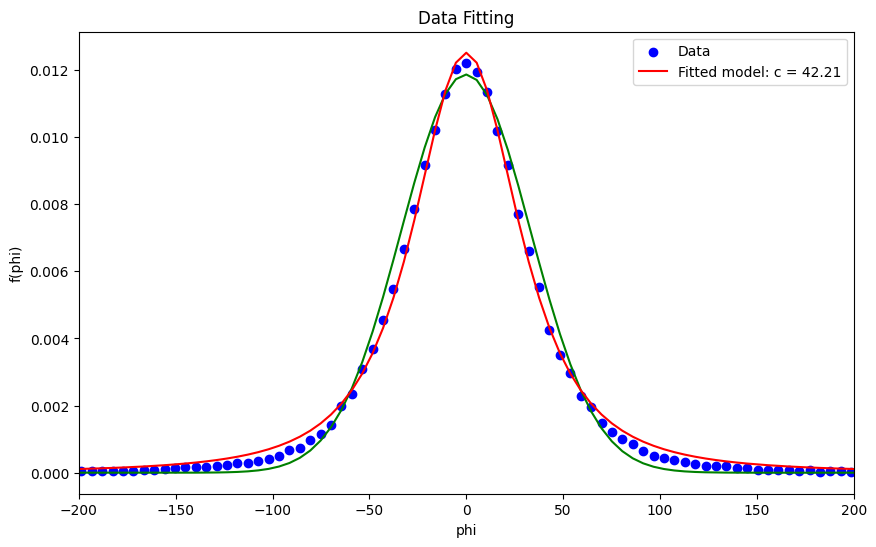

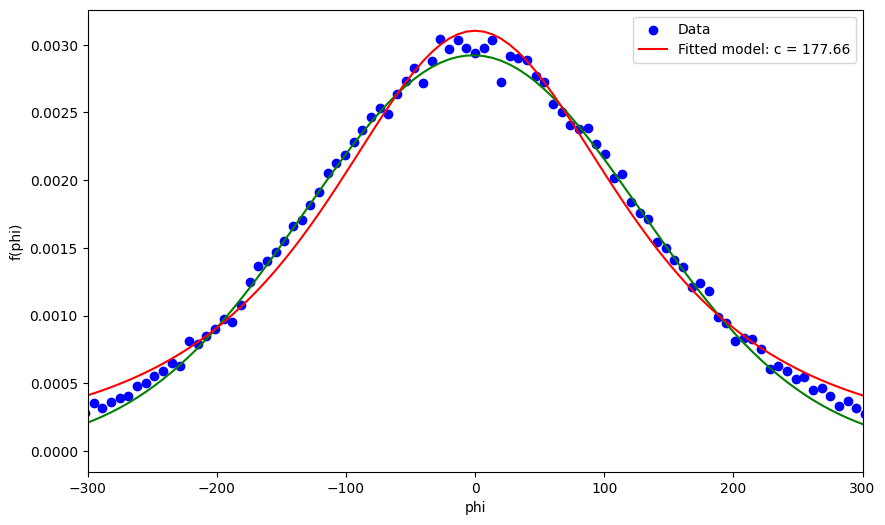

Fitted value of c: 177.65988727052942 921.0340371976183
Fitted value of d: 97.96195672499891 20000.0


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the model function
def true_function(phi, c):
    return  c/ (c**2 + (phi)**2)**(3/2)

def model_function(phi,c,d):
    return c*d/(c**2 + (phi)**2)**(3/2)


# Fit the new_model to the same data
params, covariance = curve_fit(model_function, mid1, count1,p0 = [100,0])
c_fitted = params

# Fitted parameter
print(f"Fitted value of c: {c_fitted[0]}",N1/R*M_min1*(np.log(M_max1)-np.log(M_min1)))
print(f"Fitted value of d: {c_fitted[1]}",N1/R*M_min1*M_max1)

# Generate data using the fitted parameter for plotting
y_fitted = model_function(np.array(mid1), *c_fitted)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))

plt.scatter(mid1, count1, label='Data', color='blue')
plt.plot(mid1, gaussian1(np.array(mid1),*params1), color='green')
plt.plot(mid1, y_fitted, label=f'Fitted model: c = {c_fitted[0]:.2f}', color='red')
plt.xlim(-cut1,cut1)
plt.xlabel('phi')
plt.ylabel('f(phi)')
plt.title('Data Fitting')
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))

params, covariance = curve_fit(model_function, mid2, count2,p0 = [10,0])
c_fitted = params
y_fitted = model_function(np.array(mid2), *c_fitted)

plt.scatter(mid2, count2, label='Data', color='blue')
plt.plot(mid2, gaussian2(np.array(mid2),*params2), color='green')

plt.plot(mid2, y_fitted, label=f'Fitted model: c = {c_fitted[0]:.2f}', color='red')
plt.xlim(-cut2,cut2)
plt.xlabel('phi')
plt.ylabel('f(phi)')
plt.legend()


plt.show()

print(f"Fitted value of c: {c_fitted[0]}",N2*M_min2/R*(np.log(M_max2)-np.log(M_min2)))
print(f"Fitted value of d: {c_fitted[1]}",N2*M_min2/R*M_max2)

#N1/R*M_min1*(np.log(M_max1)-np.log(M_min1))

# Encountered subhalos vs subhalo as taken from generalized distribution

Computing Samples: 100%|███████████| 2000000/2000000 [01:40<00:00, 19968.59it/s]


<Figure size 640x480 with 0 Axes>

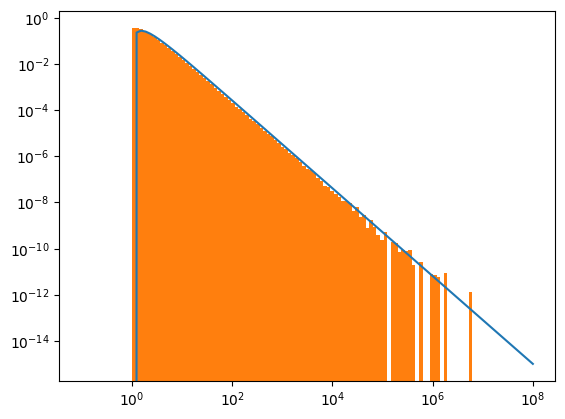

<Figure size 640x480 with 0 Axes>

In [638]:
beta = 1.9
R = 1
M_min = 1
M_max = 1e8


def generate_samples(N, M_min, M_max,R):
    ms = []
    while len(ms) < N:
        m = M_min **(beta-1) * pareto.rvs(beta-1, size=N-len(ms))
        m = m[m < M_max]
        ms.extend(m[M_min <= m])
    ms = np.array(ms[:N])
    bs = generate_impact_parameter(1, 2,size=N)
    angles = np.cos(np.random.uniform(0, 2 * np.pi, size=N))
    results = np.sum((ms * angles) / (bs))
    return results

def compute_distribution(N, M_min, M_max, R, iterations):
    results = np.zeros(iterations)
    for i in tqdm(range(iterations), desc="Computing Samples"):
        results[i] = generate_samples(N, M_min, M_max,R)
    return results


def func1(x,R,M_min, M_max):
    return 2*(beta-1)/(3-beta)*((M_min/R)**(beta-1)*x**(-beta)-(M_min/R)**2*x**(-3))

def func2(x,R,M_min,M_max):
    return 2*(beta-1)/(3-beta)*(M_min/R)**2*((M_max/M_min)**(3-beta)*x**(-3) - x**(-3))

def combined(x,R,M_min,M_max):
    if x <= M_max/R:
        return func1(x,R,M_min,M_max)
    else:
        return func2(x,R,M_min,M_max)

def combined_list(x_list, R, M_min, M_max):    
    return [combined(x,R,M_min,M_max) for x in x_list]

xs = np.logspace(-1,8,100)

plt.plot(xs,np.array(combined_list(xs,R,M_min,M_max)))

ms_scatter = compute_distribution(1,M_min,M_max,R,iterations*20)

#ms_scatter = np.array(M_min1**(beta-1)*pareto.rvs(beta-1, size=iterations*20))/np.array(pareto.rvs(2, size=20*iterations))

plt.hist(ms_scatter, bins= np.logspace(0,7,100),density =True)

plt.xscale('log')
plt.yscale('log')
plt.figure()

# Making plots

In [27]:
import numpy as np
from scipy.stats import pareto, norm
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit


beta = 1.9
def generate_samples(N, M_min, M_max,R):
    ms = []
    while len(ms) < N:
        m = M_min **(beta-1) * pareto.rvs(beta-1, size=N-len(ms))
        m = m[m < M_max]
        ms.extend(m[M_min <= m])
    ms = np.array(ms[:N])
    angles = np.cos(np.random.uniform(0, 2 * np.pi, size=N))
    results = np.sum((ms * angles))
    return results

def compute_distribution(N, M_min, M_max, R, iterations):
    results = np.zeros(iterations)
    for i in tqdm(range(iterations), desc="Computing Samples"):
        results[i] = generate_samples(N, M_min, M_max,R)
    return results


Computing Samples: 100%|█████████████| 100000/100000 [00:07<00:00, 13977.93it/s]


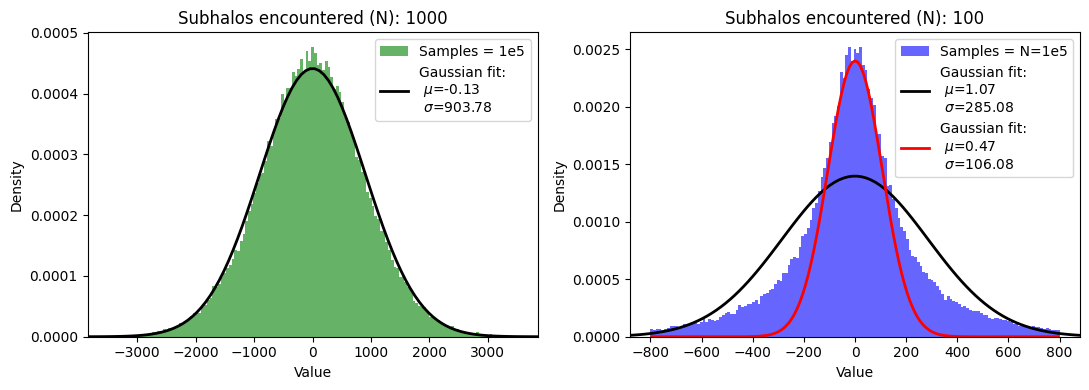

Fitted Gaussian parameters for M_max=1e2: mu = -0.13, sigma = 903.78
Fitted Gaussian parameters for M_max=1e3: mu = 1.07, sigma = 285.08


In [28]:
M_max1 = 1e3
M_max2 = 1e3
R = 1
M_min = 1
N1 = 1000
N2 = 100
iterations = int(1e5)

results1 = compute_distribution(N1, M_min, M_max1, R, iterations)
results2 = compute_distribution(N2, M_min, M_max2, R, iterations)

x_range1 = 3500
x_range2 = 800

count, sec = np.histogram(results2,bins= np.linspace(-x_range2,x_range2,150),density = True)
mid = np.array([(sec[i+1] + sec[i])/2 for i in range(len(sec)-1)])
mask = np.abs(mid) < 180

fraction = np.sum(count[mask])/np.sum(count)

def gaussian(x,m,s):
    return (fraction/np.sqrt(s**2*2*np.pi))*np.exp(-(x-m)**2/(2*s**2))

# Fit the model to the data
params, covariance = curve_fit(gaussian, mid[mask], count[mask],p0 = [0,100])


# Fit a Gaussian to the data
(mu1, sigma1) = norm.fit(results1)
(mu2, sigma2) = norm.fit(results2)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(11, 4))

# Plot for M_max = 1e2
axs[0].hist(results1, bins=np.linspace(-x_range1,x_range1,150), density=True, alpha=0.6, color='g', label='Samples = 1e5')
xmin1, xmax1 = axs[0].set_xlim()
x1 = np.linspace(xmin1, xmax1, 100)
p1 = norm.pdf(x1, mu1, sigma1)
axs[0].plot(x1, p1, 'k', linewidth=2, label=f'Gaussian fit: \n $\mu$={mu1:.2f} \n $\sigma$={sigma1:.2f}')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Density')
axs[0].set_title('Subhalos encountered (N): 1000')
#axs[0].set_xlim(-400,400)
axs[0].legend()

# Plot for M_max = 1e3
axs[1].hist(results2, np.linspace(-x_range2,x_range2,150), density=True, alpha=0.6, color='b', label='Samples = N=1e5')
xmin2, xmax2 = axs[1].set_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu1, sigma1/np.sqrt(10))
axs[1].plot(x2, p2, 'k', linewidth=2, label=f'Gaussian fit: \n $\mu$={mu2:.2f} \n $\sigma$={sigma2:.2f}')
axs[1].plot(mid, gaussian(mid,*params), 'r', linewidth=2, label=f'Gaussian fit: \n $\mu$={params[0]:.2f} \n $\sigma$={params[1]:.2f}')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Density')
axs[1].set_title('Subhalos encountered (N): 100')
#axs[1].set_xlim(-400,400)
axs[1].legend()

plt.tight_layout()
plt.show()

# Print the fitted parameters
print(f'Fitted Gaussian parameters for M_max=1e2: mu = {mu1:.2f}, sigma = {sigma1:.2f}')
print(f'Fitted Gaussian parameters for M_max=1e3: mu = {mu2:.2f}, sigma = {sigma2:.2f}')